## NB2. ROF monthly, annual, seasonal discharge at ocean outlets <a id='top'></a>

Use 

1. reach-D19 gauge link ascii
2. D19 flow site geopackage
3. D19 discharge netCDF
4. monthly and yearly flow netCD (history file)

[1. Setupt](#setup)

[2. Loading data](#load_data)

- monthly history files (directory from CESM or postprocessed) from archive. 

- Reference data is monthly discharge estimates at 922 big river mouths from Dai et al. 2019 data (D19)

[3. Read river, catchment, gauge information](#read_meta)

- xxx

[4. Ocean discharge line plots](#922_rivers)

- total seasonal flow for oceans. 


In [2]:
%matplotlib inline

import os, sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask_jobqueue import PBSCluster
from dask.distributed import Client

from scripts.utility import load_yaml 
from scripts.utility import no_time_variable
from scripts.utility import read_shps
from scripts.utility import get_index_array

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)
print(pd.__name__, pd.__version__)
print(gpd.__name__, gpd.__version__)


The Python version: 3.11.4
xarray 2024.7.0
pandas 2.2.2
geopandas 1.0.1


-------------------------
## 1. Analysis setup <a id='setup'></a>

**Please provide CESM case names and ROF grid name**

[go back to top](#top)

In [4]:
# CESM case names and their runoff grid
plot_name = 'test'

cases = {
        'f09_f09_rHDMA':'rHDMA',
        'f09_f09_rHDMAlk':'rHDMAlk',
        'f09_f09_rHDMAlk_h06':'rHDMAlk_h06',
        #'f09_f09_rHDMAlk_mg17_irrig':'rHDMAlk_irrig',
        #'f09_f09_mg17':'f09_f09',
        'f09_f09_mg17_mosart':'f09_f09_mosart',
        }

parallel =  False

-------------------------
load config files and some parameters 

In [5]:
setup = load_yaml('./setup/setup.yaml')

main_dir       = setup['archive_dir']     # CESM archive directory
domain_dir     = setup['ancillary_dir']   # ancillary directory including such as ROF domain, river network data
geospatial_dir = setup['geospatial_dir']  # including shapefiles or geopackages
ref_flow_dir   = setup['ref_flow_dir']    # including observed or reference flow data

syr            = setup['syr']             # analysis start year
eyr            = setup['eyr']             # analysis end year

rof_grid       = setup['rof_grid']        # RO grid meta
catch_gpkg     = setup['catch_gpkg']      # catchment geopackage meta
reach_gpkg     = setup['reach_gpkg']      # reach geopackage meta
network_nc     = setup['river_network']   # river network meta

time_period = slice(f'{syr}-01-01',f'{eyr}-12-31') # analysis time period
nyrs = eyr-syr+1  # number of years
nmons = nyrs*12   # number of months

In [6]:
oceans_list = ['arctic', 'atlantic', 'indian', 'mediterranean', 'pacific', 'south_china', 'global']

-----
### dasks (optional)

In [7]:
if parallel:
    cluster = PBSCluster(queue='casper', memory='10GB', processes=1)
    cluster.scale(jobs=10)
    client = Client(cluster)
    client

## 2. Loading data <a id='load_data'></a>

[go back to top](#top)

### 2.1. Mmonthly/annual flow netCDFs
- month_data (xr dataset)
- year_data (xr dataset)
- seas_data (xr dataset)

In [8]:
%%time

reachID    = {}
month_data = {}
year_data  = {}
seas_data  = {}
for case, grid_name in cases.items():
    in_dire = os.path.join(main_dir, case, 'rof/hist')
    model  = rof_grid[grid_name]['model']
    domain = rof_grid[grid_name]['domain_nc']
    #monthly
    month_data[case] = xr.open_mfdataset(f'{in_dire}/{case}.{model}.*.month.nc', data_vars='minimal', chunks={'time':12}).sel(time=time_period).load()
    #annual
    year_data[case] = xr.open_mfdataset(f'{in_dire}/{case}.{model}.*.annual.nc', data_vars='minimal', chunks={'time':1}).sel(time=time_period).load()
    #seasonal (compute here instead of reading because of different time period)
    seas_data[case] = month_data[case].groupby('time.month').mean('time')
    vars_no_time = no_time_variable(month_data[case])
    seas_data[case][vars_no_time] = seas_data[case][vars_no_time].isel(month=0, drop=True)
    
    if domain=='None':  #wish domain = None (not string)
        reachID[case] = month_data[case]['reachID'].values
    else:
        reachID[case] = xr.open_dataset(f'{domain_dir}/{domain}')['reachID'].stack(seg=('lat', 'lon')).values
    print(case)

f09_f09_rHDMA
f09_f09_rHDMAlk
f09_f09_rHDMAlk_h06
f09_f09_mg17_mosart
CPU times: user 16.4 s, sys: 3.75 s, total: 20.2 s
Wall time: 1min 34s


### 2.2 D19 discharge data
- ds_q_obs_mon (xr datasets)
- ds_q_obs_yr (xr datasets)
- dr_q_obs_seasonal (xr datasets)

In [10]:
%%time

# read monthly data
ds_q = xr.open_dataset('%s/D09/coastal-stns-Vol-monthly.updated-May2019.mod.nc'%(ref_flow_dir),decode_times=False)
ds_q['time'] = xr.cftime_range(start='1900-01-01', end='2018-12-01', freq="MS", calendar="standard")

# monthly
ds_q_obs_mon = ds_q['FLOW'].sel(time=time_period)
# compute annual flow from monthly
ds_q_obs_yr = ds_q_obs_mon.resample(time="YE").mean(dim="time")
# compute annual cycle at monthly scale
dr_q_obs_seasonal = ds_q_obs_mon.sel(time=time_period).groupby('time.month').mean('time')

CPU times: user 66.2 ms, sys: 426 μs, total: 66.6 ms
Wall time: 68.4 ms


## 3. Reading river, catchment, gauge infomation  <a id='read_meta'></a>

- catchment polygon (geopackage)
- gauge point (geopackage)
- gauge-catchment link (csv)
- outlet reach information (netCDF)

[go back to top](#top)

### 3.1. reach-D19 gauge link csv
- gauge_reach_lnk (dataframe)

In [11]:
gauge_reach_lnk = {}
for case, grid_name in cases.items():
    gauge_reach_lnk[case] = pd.read_csv('%s/D09/D09_925.%s.asc'%(ref_flow_dir, rof_grid[grid_name]['network']))

### 3.2 D19 flow site shapefile
- gauge_shp (dataframe)

In [12]:
%%time

gauge_shp = gpd.read_file(os.path.join(ref_flow_dir, 'D09','geospatial','D09_925.gpkg'))
gauge_shp = gauge_shp[gauge_shp['id']!=9999999]

CPU times: user 15.7 ms, sys: 6.97 ms, total: 22.7 ms
Wall time: 80.6 ms


In [13]:
%%time

ocean_shp = gpd.read_file(os.path.join(geospatial_dir, 'oceans.gpkg'))

CPU times: user 289 ms, sys: 140 ms, total: 429 ms
Wall time: 857 ms


### 3.3 Read river network information
- riv_ocean (dataframe)

In [14]:
%%time

## read catchment geopackage
gdf_cat={}
for case, grid_name in cases.items():
    network_name = rof_grid[grid_name]['network']

    cat_gpkg = os.path.join(geospatial_dir, catch_gpkg[network_name]['file_name'])  # geopackage name
    id_name_cat = catch_gpkg[network_name]['id_name']                              # reach ID in geopackage
    var_list = [id_name_cat]
    if 'lk' in grid_name:
        var_list.append('lake')
    gdf_cat[case] = read_shps([cat_gpkg], var_list)

Finished reading /glade/campaign/cgd/tss/people/mizukami/ctsm-mizuRoute/geospatial/hdma_global_catch_v2_0.01.gpkg
Finished reading /glade/campaign/cgd/tss/people/mizukami/ctsm-mizuRoute/geospatial/hdma_hydrolake_global_catch_v1_0.01.gpkg
Finished reading /glade/campaign/cgd/tss/people/mizukami/ctsm-mizuRoute/geospatial/hdma_hydrolake_global_catch_v1_0.01.gpkg
Finished reading /glade/campaign/cgd/tss/people/mizukami/ctsm-mizuRoute/geospatial/MOSART_routing_Global_0.5x0.5_c170601_hru.gpkg
CPU times: user 4.67 s, sys: 910 ms, total: 5.58 s
Wall time: 7.15 s


In [15]:
%%time

# read river outlet netcdf
riv_ocean={}
for case, grid_name in cases.items():
    network = rof_grid[grid_name]['network']
    riv_ocean_file = os.path.join(domain_dir, network_nc[network]['file_name'].replace('.aug.nc','.outlet.nc'))  # network netcdf name
    ds_rn_ocean = xr.open_dataset(riv_ocean_file).set_index(seg='seg_id')
    df_tmp = ds_rn_ocean.to_dataframe()
    riv_ocean[case] = pd.merge(gdf_cat[case], df_tmp, left_on=catch_gpkg[network]['id_name'], right_index=True)

CPU times: user 1.42 s, sys: 149 ms, total: 1.57 s
Wall time: 1.72 s


### 2.6 Merge gauge, outlet catchment dataframe

- gauge_shp1 (dataframe)

In [16]:
%%time

# Merge gauge_reach lnk (dataframe) into gauge shapefile
gauge_shp1={}
for case, df in gauge_reach_lnk.items():
    network = rof_grid[cases[case]]['network']
    
    #df = df.loc[(df['flag'] == 0)]
    df1 = df.drop(columns=['riv_name'])
    df2 = pd.merge(gauge_shp, df1, how="inner", left_on="id", right_on="gauge_id")
    gauge_shp1[case]  = pd.merge(df2, riv_ocean[case], how="inner", left_on="route_id", right_on=catch_gpkg[network]['id_name'])

CPU times: user 53.6 ms, sys: 0 ns, total: 53.6 ms
Wall time: 80.9 ms


------
## 4. plot annual cycle for global oceans <a id='24_large_rivers'></a>

TODO: Referece flow plot should be independent from cases (network). Currently the last case plotted looks better matched with reference flow. 

[go back to top](#top)

In [3]:
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
land = cfeature.LAND

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.25 μs


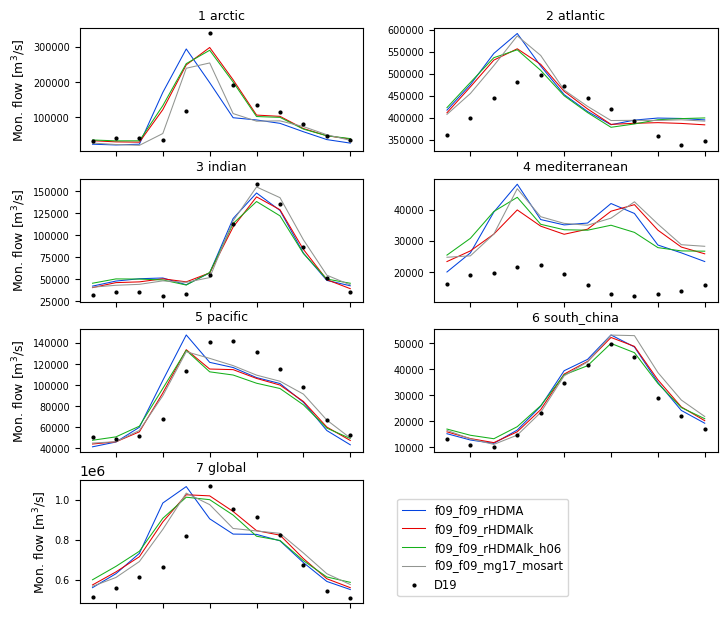

In [17]:
%time

nrows=4; ncols=2
fig, axes = plt.subplots(nrows, ncols, figsize=(7.25, 6.5))
plt.subplots_adjust(top = 0.95, bottom = 0.065, right = 0.98, left = 0.10, hspace=0.225, wspace=0.250)# create some space below the plots by increasing the bottom-value

for ix, ocean_name in enumerate(oceans_list):
    row = ix // 2
    col = ix % 2
    for case in cases:
        grid_name = cases[case]
        
        q_name = rof_grid[grid_name]['flow_name']
        color  = rof_grid[grid_name]['color']
        
        if rof_grid[grid_name]['network_type']=='vector': 
            if ocean_name=='global':
                id_list = gauge_shp1[case]['route_id'].values
            else:
                id_list = gauge_shp1[case][gauge_shp1[case]['ocean']==ocean_name]['route_id'].values
            reach_index = get_index_array(reachID[case], id_list)
            dr_flow = seas_data[case][q_name].isel(seg=reach_index).sum(dim='seg')
            dr_flow.plot(ax=axes[row,col], linestyle='-', c=color, lw=0.75, label=case)

        elif rof_grid[grid_name]['network_type']=='grid':   # means 2d grid 
            if ocean_name=='global':
                id_list = gauge_shp1[case]['route_id'].values
            else:
                id_list = gauge_shp1[case][gauge_shp1[case]['ocean']==ocean_name]['route_id'].values

            reach_index = get_index_array(reachID[case], id_list)
            seas_data_vector = seas_data[case][q_name].stack(seg=('lat', 'lon'))
            dr_flow = seas_data_vector.isel(seg=reach_index).sum(dim='seg')
            dr_flow.plot(ax=axes[row,col], linestyle='-', c=color, lw=0.75, label=case)
            
    # reference data
    if ocean_name=='global':
        id_list = gauge_shp1[case]['id'].values
    else:
        id_list = gauge_shp1[case][gauge_shp1[case]['ocean']==ocean_name]['id'].values
    gauge_index = get_index_array(ds_q['id'].values, id_list)
    dr_obs = dr_q_obs_seasonal.isel(station=gauge_index).sum(dim='station')
    dr_obs.plot(ax=axes[row,col],linestyle='None',marker='o',markersize=2, c='k',label='D19')
    
    axes[row,col].set_title('%d %s'%(ix+1,ocean_name), fontsize=9)
    axes[row,col].set_xlabel('')
    if row < 7:
        axes[row,col].set_xticklabels('')
    if col == 0:
        axes[row,col].set_ylabel('Mon. flow [m$^3$/s]', fontsize=9)
    else: 
        axes[row,col].set_ylabel('')
    axes[row,col].tick_params('both',labelsize='x-small')
    
#Legend- make space below the plot-raise bottom. there will be an label below the second last (bottom middle) ax, thanks to the bbox_to_anchor=(x, y) with a negative y-value. 
axes[row,col].legend(loc='center left', bbox_to_anchor=(1.10, 0.40, 0.75, 0.1), ncol=1, fontsize="small")    

for jx in range(ix+1,nrows*ncols):
    row = jx // 2
    col = jx % 2
    fig.delaxes(axes[row][col])

plt.savefig(f"./Figures/NB2_Fig1_ocean_discharge_season_{plot_name}.png", dpi=200)